<a href="https://colab.research.google.com/github/UOS-COMP6252/public/blob/main/lecture2/logistic-regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="text-align: center;">COMP6252 Deep Learning Technologies</h1>
<h2 style="text-align: center;"> Lecture 2</h2>

# What you will learn in this notebook
 
1. Explain stochastic gradient descent
1. Apply PyTorch DataLoader
1. Use logistic regression for binary classification
1. Implement a binary classifier in PyTorch 
2. Use Comet platform to log results


In [ ]:
## We will be using comet_ml to log our experiments
import comet_ml

## CIFAR10 Dataset

- We use the CIFAR10 dataset to perform binary classification

In [ ]:
import torch 
import torchvision as vision

cifar10_train=vision.datasets.CIFAR10(".",download=True,train=True)# train=True is the default
cifar10_test=vision.datasets.CIFAR10(".",download=True,train=False)

In [ ]:
# Plot the first image (a frog) and set the corresponding label as title
img0,label0=cifar10_train[0]
print(type(img0))
import matplotlib.pyplot as plt
fig=plt.figure()
fig.set_size_inches(1,1)
p=fig.add_subplot()

p.set_title(str(label0))
p.axes.get_xaxis().set_visible(False)
p.axes.get_yaxis().set_visible(False)
plt.imshow(img0)

### Data transforms
- Recall from last session that CIFAR10 contains a set of images/labels. To use the dataset with PyTorch we need to **transform** the data to tensors

In [ ]:
image,label=cifar10_train[0]
print(type(image),type(label))
print(type(image),type(label))

In [ ]:
from torchvision.transforms import ToTensor
cifar10_train=vision.datasets.CIFAR10(".",download=True,train=True,transform=ToTensor())
cifar10_test=vision.datasets.CIFAR10(".",download=True,train=False,transform=ToTensor())
img,label=cifar10_train[0]
print(type(img))

### Binary classification

- The dataset has 10 classes: Airplanes,Cars,Birds,Cats,Deers,Dogs,Frogs,Horses, Ships and Trucks
- For simplicity we will rearrange it into only 2 classes
    - Animate: Birds, Cats,Deers,Dogs, Frogs, Horses
    - Inanimate: Airplanes, Cars, Ships and Trucks

- Rearrange both the train and test datasets
- Why didn't we use ```label=1``` and ```label=0``` in the code below ?
- Use Vevox session 131-699-292

In [ ]:
#airplane=0,car=1,bird=2,cat=3,deer=4,dog=5,frog=6,horse=7,ship=8,truck=9
features=torch.tensor([0,1,8,9])
for i, (img,label) in enumerate(cifar10_train):
    if torch.isin(label,features):
        cifar10_train.targets[i]=1
    else:
        cifar10_train.targets[i]=0
for i, (img,label) in enumerate(cifar10_test):
    if torch.isin(label,features):
        cifar10_test.targets[i]=1
    else:
        cifar10_test.targets[i]=0

### Stochastic gradient descent

- So far the gradient was computed over the whole dataset
    - In many situations this is not feasible, e.g. not enough memory
- A good approximation is **stochastic** gradient descent
    - The gradient is computed for a single sample
- Another, most commonly used variant, is to compute the gradient over a random subset of the dataset **(batch)**
    - Saves memory
    - Better chance to escape local minima
    - Usually called **mini batch** GD
- Another advantage of SGD is it helps us get out of local minima
- Henceforth, when we say GD or SGD we mean mini batch gradient descent.

### Data loader
- SGD is more efficient when the batches are randomly selected
- PyTorch provides a convenient class for operations on batches: ```DataLoader```
- ```num_workers``` is the number of threads used for parallel processing
- ```shuffle=True``` means the dataset is randomly shuffled after a complete pass

In [ ]:
from torch.utils.data import DataLoader
batch_size=64
train_loader=DataLoader(cifar10_train,shuffle=True,batch_size=batch_size,num_workers=2)
test_loader=DataLoader(cifar10_test,batch_size=batch_size,num_workers=2)

- Recall that the images have 3 channels and are 32x32. The batch size=64
- What is the shape of **imgs** and **labels** in the code below?
- Use Vevox session 131-699-292

In [ ]:
itr=iter(train_loader)
imgs,labels=next(itr)
print(imgs.size(),labels.size())



## Logistic Regression

- Logistic Regression can be regarded as the **simplest neural network**, a single "neuron". 
- It takes as input a vector of size $n$ and it feeds a single unit (a neuron or perceptron). 
- The neuron is represented by a vector of **learnable** weights $w$ and bias $b$
- The output is the sum of $b$ and the **dot** product between $w$ and the vector input $x$
- The result is fed into some function (usually nonlinear) $f$ called the activation.



$$
\begin{align*}
z&=\sum_iw_i\cdot x_i+b\\
\hat{y}(x)&=f(z)
\end{align*}
$$

- Note that because $z$ depends on $W$ and $b$ so does $\hat{y}$. 
- Therefore our task is to **learn** the "best" values of $W$ and $b$ to model the data



- The input $x$ and $f$ are **known** whereas $w$ and $b$ are **parameters** to be determined. 
- Our goal is to find the _optimal_ $w$ and $b$ such that the output is as *close as possible* to the label associated with the input.

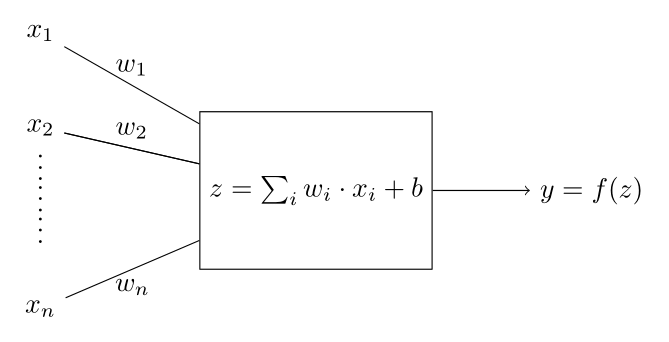


- How is "**as close as possible**" defined? 
- The dataset is usually a set of pairs $(x,y)$. 
- We define the loss as the **deviation** between the label $y$ and the result $\hat{y}=f(z)$

$$loss=\mathcal{L}_{w,b}(y,\hat{y})$$

- The function $\mathcal{L}$ depends on the problem (for example binary cross entropy, mean squared error,...)

- Note that $\mathcal{L}$ depends on the parameters $w,b$. 
- Our goal is to find the **optimal** $w,b$ such that $\mathcal{L}$ is minimal. 

## Sigmoid

- So far we have not specified the function _f_ that our  model depends on $\hat{y}=f(z)$. 
- In this example we use the **sigmoid** function. Given an input _z_ it has the form

$$
\begin{align*}
\sigma=\frac{1}{1+e^{-z}}
\end{align*}
$$
- The values of $\sigma$ go from 0 to 1 which we interpret as the probability that the label is 1
- $1-\sigma$ is the probability that the label is 0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
z=[1/(1+np.exp(-x)) for x in range(-10,11)]
plt.plot([x for x in range(-10,11)],z)
plt.xticks([t for t in range(-10,11,2)])
plt.show()

## Flattening the images
- The input images have dimensions (3,32,32) (3 channels, 32 height,32 width). 
- To use them as input to the "neuron" we need to "flatten" the input
- One can use the ```.reshape``` method

In [ ]:
itr=iter(train_loader)
imgs,labels=next(itr)
imgs=imgs.reshape(batch_size,-1)
print(imgs.shape,labels.shape)
torch.unique(labels)

- One can use ```reshape``` but it is a bit clumsy if the size of the datasets is **not** a multiple of the batch size
- For CIFAR10 there are 50000 training samples. 
- That's 781 batches of size 64 and the last has size 16: ```50000=781*64+16```

In [ ]:
for batch in train_loader:
    imgs,labels=batch
    
print(imgs.shape,labels.shape)
len(train_loader)*batch_size

To make sure that we get batches of the same size we use ```drop_last``` in the data loaders


In [ ]:
train_loader=DataLoader(cifar10_train,shuffle=True,batch_size=batch_size,num_workers=2,drop_last=True)
test_loader=DataLoader(cifar10_test,batch_size=batch_size,num_workers=2,drop_last=True)

### Use of ```flatten```

- It is more convenient to use ```tensor.flatten(start_dim=d)```
- Where ```d``` specifies from which dimension to start "flattening"

In [ ]:
print(imgs.shape)
print(imgs.flatten(start_dim=0).shape,imgs.flatten(start_dim=1).shape)

## Initialize the parameters
- The goal is to find the **optimal** values for the parameters, $w$ and $b$. 
- Intially we give them random values (for weights) and 0 for the bias as shown below. 
- Note that
    - The `reguires_grad` declares a tensor to be a variable
    - In previous versions of Pytorch one needed to declare variables explicitly but this is deprecated now. See [here](https://pytorch.org/docs/stable/autograd.html#variable-deprecated)

In [ ]:
weights=torch.randn(3*32*32,requires_grad=True,dtype=torch.float32)
bias=torch.tensor(0.,requires_grad=True,dtype=torch.float32)

### Binary cross-entropy loss
- Binary cross-entropy is the loss used for binary classification problems.
- Recall that $\sigma(z)$ is the probability that $z(x)$ corresponds to an inanimate object
- The corresponding distribution is Bernoulli
$$ B(z)=\sigma^y(1-\sigma)^{1-y}$$
- the log-likelihood
$$\mathcal{L}=y\log\sigma+(1-y)\log(1-\sigma)$$
- Where $y$ is the label corresponding to $x$

## Optimization loop

In [ ]:
rate=0.015
loss_fn=torch.nn.BCELoss()
epochs=10
for epoch in range(epochs):
    epoch_loss=0
    count=0
    for imgs,labels in train_loader:
        count+=1
        imgs=imgs.flatten(start_dim=1)
        #compute z=wx+b
        z=torch.matmul(imgs,weights)+bias
        y_hat=torch.sigmoid(z)
        loss=loss_fn(y_hat,labels.float())
        # compute the gradients
        dw,db=torch.autograd.grad(loss,[weights,bias])
        #update the weights and bias
        # Note the in-place operation
        weights.data-=rate*dw
        bias.data-=rate*db
        epoch_loss+=loss.item()
  
    print("loss {:.4f}".format(epoch_loss/count))

## Prediction on the test data

- An important measure of any ML method is how well it "generalizes". 
- This is done by using the trained model on **test** data, i.e. data that it **was not** trained on 
- But the output of our model is the probability that the input is a "machine", which could be any value between 0 and 1. 
- The test labels are discrete values of 0 and 1 so how do we compare them? 
- We regard a probability $\ge 0.5$ to be 1 and $< 0.5$ to be 0

### Measuring accuracy

In [ ]:
def predict(loader):
    total=0.
    for imgs,labels in loader:
        imgs=imgs.flatten(start_dim=1)
        z=torch.matmul(imgs,weights)+bias
        y_hat=torch.sigmoid(z)
        ones=y_hat>0.5
        ## count how many outputs are equal to the "true" labels
        r=ones==labels
        ## add them to the total
        total+=r.sum()
    # len(loader) is the number of batches
    return total/(len(loader)*batch_size)

In [ ]:
predict(test_loader)

## Abstracting the model and training pipeline using Pytorch

- The model we have used  is simple enough to code directly. 
- We only needed Pytorch to compute the loss and gradients. 
- For more complicated models this process becomes unwieldy. 
- We can use Pytorch to abstract away the details.  
- The abstractions offered by Pytorch are illustrated below to solve the same problem that we just did. 

### Using comet to log results

Comet is a cloud platform that integrates with many ML frameworks, including PyTorch, and can be used to log and visualise ML experiments 

In [ ]:
experiment = comet_ml.Experiment(workspace="COMP6252",project_name="DL intro",auto_metric_logging=False,auto_param_logging=False)


### The model

- The model we plan to use is encapsulated in a class that **inherits** from ```torch.nn.Module```

- All we need to do is **override** two methods:
1. ```__init__```. As you would have guessed this is called when the object is constructed to initialize our model
1. ``` forward```. This is called to perform a forward computation

In [ ]:
import torch.nn as nn

class Net(nn.Module):
  def __init__(self,in_features,out_features):
    super(Net, self).__init__()
    self.input_size=in_features
    self.output_size=out_features
    # declaring weights and bias as parameters so that they are included
    # in the return value of .parameters()
    self.weights=nn.Parameter(torch.randn(in_features,requires_grad=True,dtype=torch.float32))
    self.bias=nn.Parameter(torch.tensor(0.,requires_grad=True,dtype=torch.float32))
    
  def forward(self,input):  
    y_hat=input.flatten(start_dim=1)
    y_hat=torch.matmul(y_hat,self.weights)+self.bias
    y_hat=torch.sigmoid(y_hat)
    return y_hat

- Note that in the initialization, the weights and bias are constructed as ```Parameter```. 
- This is so that we can use the ```.parameters()``` call and pass it to the optimizer.
- Next we create an instance of the model

In [ ]:
model=Net(3*32*32,1)

Recall that each learning iteration performs a number of steps. 
1. Compute the forward pass over the input to get the output. This is now done using ```model.forward()``` indirectly by calling ```model(input)```
1. Compute the loss using an appropriate loss function. Same as before
1. Compute the gradients using ```loss.backward()```.
    


- ```backward()``` computes the gradient with respect to the parameters AND saves them in the ```.grad``` attributes
- For example, if ```p``` is a parameters then ```loss.backward()``` computes the gradient of ```loss``` wrt ```p``` AND saves the result in ```p.grad```
- Once the gradients are computed
1. The optimizer updates the parameters. 
    - This is done by the optimizer using ```optimizer.step()```. 
1. This is important since later on we will use optimizers that use a different strategy to update the parameters.

In [ ]:
rate=0.015
experiment.log_parameters({"batch_size":batch_size,"learning rate":rate})
import torch.optim as optim
optimizer=optim.SGD(model.parameters(),lr=rate)
loss_fn=torch.nn.BCELoss()
epochs=20

for epoch in range(epochs):
  epoch_loss=0
  count=0
  
  for imgs,labels in train_loader:
    count+=1
  # uses the .forward() method to get y_hat
    y_hat=model(imgs)
  # as before
    loss=loss_fn(y_hat,labels.float())
  # Computes the gradients and saves them in the appropriate .grad
    loss.backward()
  # updates the parameters using the computed .grad
    optimizer.step()
  # zero the .grad values so that they don't accumulate
    optimizer.zero_grad()
    epoch_loss+=loss.item()
  experiment.log_metric("loss",epoch_loss/count,epoch=epoch)
  print("loss {:.4f}".format(epoch_loss/count))

In [ ]:
def predict(loader):
    total=0.
    for imgs,labels in loader:
        outputs=model(imgs)
        ones=outputs>0.5
        r=ones==labels
        total+=r.sum()
    # Compute vector "y_hat" predicting
    # the probabilities of a machine being present in the picture
    
    return total/len(loader.dataset)

In [ ]:
accuracy=predict(test_loader)
experiment.log_metric("accuracy",accuracy)
### display the experiment inline
### a bit clumsy, better to use the link shown when the experiment is created
##to see the results
#experiment.display()
experiment.end()
